# Soccer analysis and prediction

# Import Libraries

In [37]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from elo import rate_1vs1

from wordcloud import WordCloud
import nltk

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,f1_score,accuracy_score

# Loading data

## Matches data of previous seasons

In [38]:
matches=pd.read_csv('MatchData.csv',low_memory=False) 
matches2 = matches.loc[:, matches.columns.intersection(['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','Season'])]
matches=pd.read_csv('CleanMatchData.csv',low_memory=False) 

In [39]:
matches.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season
0,Barcelona,Malaga,2,1,H,2,0,H,2000
1,La Coruna,Ath Bilbao,2,0,H,0,0,D,2000
2,Real Madrid,Valencia,2,1,H,0,0,D,2000
3,Sociedad,Santander,2,2,D,0,0,D,2000
4,Zaragoza,Espanol,1,2,A,0,0,D,2000


## Players data
##### Contains statistics of players in last three seasons in a list

In [40]:
players=pd.read_csv('player_scraper/playerdata.csv',low_memory=False)

In [41]:
players.head()

,name,goals_per90,assists_per90,goals_assists_pens_per90,goals_pens_per90,goals,shots_total_per90,shots_on_target_per90,shots_free_kicks,pens_made,...,dribbles_vs,pressures,pressure_regains,blocks,blocked_shots,dribbles_completed,carry_distance,fouls,aerials_won,ball_recoveries
0,Andriy Lunin,"['0.00', None, None]","['0.00', None, None]","['0.00', None, None]","['0.00', None, None]",NaN,NaN,NaN,NaN,NaN,...,"[None, '0', None]","[None, '0', None]","[None, '0', None]","[None, '1', None]","[None, '0', None]","[None, '0', None]","[None, '249', None]","0,0,1","[None, '0', None]","[None, '21', None]"
1,Víctor Chust,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Thibaut Courtois,"0.00,0.00,0.00","0.00,0.00,0.00","0.00,0.00,0.00","0.00,0.00,0.00","0,0,0","0.04,0.03,0.00","0.00,0.03,0.00","0,0,0","0,0,0",...,"3,2,0","3,1,1","0,0,0","0,0,0","0,0,0","1,0,0","2317,3238,564","0,0,0","0,1,0","118,161,13"
3,Diego Altube,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alfonso Espino,"0.00,0.03,0.00","0.21,0.06,0.00","0.21,0.09,0.00","0.00,0.03,0.00","0,1,0","[None, '0.49', '0.40']","[None, '0.09', '0.00']","[None, None, '0']","0,0,0",...,"[None, None, '15']","[None, None, '87']","[None, None, '23']","[None, None, '15']","[None, None, '0']","[None, None, '3']","[None, None, '470']","[None, '58', '6']","[None, None, '3']","[None, None, '45']"


## Cleaning Player data
##### We will compute the average of the three seasons for all stats

In [42]:
def calcaverage(listt):
    if(pd.isna(listt)):
        return
    else:
        listt=listt.strip('][').split(',')
        cc=0
        val=0
        for x in listt:
            x=x.strip('\' ')
            if(x!="None"):
                cc+=1
                val=val+float(x)
        if(cc==0):
            return
        return (val/cc)

for c in players.columns:
    if(c=="name"):
        continue
    players[c]=players[c].apply(calcaverage)

For each of the stats point I will give a percentile score to each of the player , this will help us to compare players

In [43]:
def calcscore(x):
    return scipy.stats.percentileofscore(players[c].to_numpy(), x , kind='rank')

currentcol = ""
playerscores = pd.DataFrame()
for c in players.columns:
    if(c=="name"):
        playerscores[c] = players[c]
        continue
    playerscores[c] = players[c].apply(calcscore)

In [44]:
temp=playerscores.sort_values(by="goals_assists_pens_per90",ascending=False)
temp.head()

,name,goals_per90,assists_per90,goals_assists_pens_per90,goals_pens_per90,goals,shots_total_per90,shots_on_target_per90,shots_free_kicks,pens_made,...,dribbles_vs,pressures,pressure_regains,blocks,blocked_shots,dribbles_completed,carry_distance,fouls,aerials_won,ball_recoveries
160,Antonio Cortés,91.187739,15.900383,91.187739,91.187739,58.716475,73.563218,79.693487,28.544061,33.141762,...,14.080460,25.478927,25.383142,18.869732,13.122605,38.218391,18.007663,45.114943,31.034483,15.134100
163,Roberto López,88.505747,90.996169,90.996169,88.697318,33.812261,51.915709,60.919540,65.038314,33.141762,...,10.919540,13.601533,14.176245,15.038314,13.122605,17.528736,8.045977,7.375479,25.670498,12.260536
274,Denis Cheryshev,55.842912,91.187739,90.804598,57.279693,42.911877,48.850575,50.191571,28.544061,33.141762,...,67.528736,71.647510,67.528736,66.858238,50.862069,63.122605,56.321839,72.126437,54.406130,48.084291
296,Luis Suárez,90.613027,89.463602,90.613027,90.613027,79.885057,79.310345,79.310345,73.754789,76.724138,...,37.068966,65.325670,63.984674,47.892720,46.647510,81.896552,64.559387,55.076628,32.758621,43.295019
275,Ansu Fati,90.804598,50.478927,90.421456,90.804598,72.796935,73.180077,77.969349,28.544061,33.141762,...,40.900383,49.042146,50.287356,43.582375,31.800766,70.785441,63.601533,37.835249,28.639847,28.065134


# Data analysis and visualisation

## ELO ratings for teams

In [45]:
# List of all teams
teamset=set()
for team in matches['HomeTeam']:
    teamset.add(team)
for team in matches['AwayTeam']:
    teamset.add(team)
print(teamset)

{'Valencia', 'Betis', 'Mallorca', 'Zaragoza', 'Xerez', 'Elche', 'Ath Bilbao', 'Santander', 'Osasuna', 'Ath Madrid', 'Espanol', 'Granada', 'Las Palmas', 'Gimnastic', 'Villarreal', 'Sociedad', 'Barcelona', 'Malaga', 'Levante', 'Almeria', 'Oviedo', 'Huesca', 'Alaves', 'Real Madrid', 'Recreativo', 'Hercules', 'Leganes', 'Girona', 'La Coruna', 'Sevilla', 'Valladolid', 'Vallecano', 'Albacete', 'Murcia', 'Sp Gijon', 'Cordoba', 'Numancia', 'Getafe', 'Cadiz', 'Celta', 'Eibar', 'Tenerife'}


In [46]:
# TeamData of each and every team 
teamsdata={}
for team in teamset:
    teamdata={}
    teamdata['matches_played']=0
    teamdata['won']=0
    teamdata['tie']=0
    teamdata['elo']=1200  # Default rating
    teamsdata[team]=teamdata

In [47]:
for index, row in matches.iterrows(): 
    ht=row['HomeTeam']
    teamsdata[ht]['matches_played']+=1
    at=row["AwayTeam"]
    teamsdata[at]['matches_played']+=1
    result=row['FTR']
    if(result=='D'):
        teamsdata[ht]['tie']+=1
        teamsdata[at]['tie']+=1
        wer=teamsdata[ht]['elo']
        ler=teamsdata[at]['elo']
        nwer , nler = rate_1vs1(wer,ler,drawn=True)
        teamsdata[ht]['elo']=nwer
        teamsdata[at]['elo']=nler
    else:
        winner=ht if result=='H' else at
        loser=at if result=='H' else ht
        teamsdata[winner]['won']+=1
        # Update elo ratings
        wer=teamsdata[winner]['elo']
        ler=teamsdata[loser]['elo']
        nwer , nler = rate_1vs1(wer,ler)
        teamsdata[winner]['elo']=nwer
        teamsdata[loser]['elo']=nler        

### Top Teams based on ELO ratings

In [48]:
teamstable=pd.DataFrame.from_dict(teamsdata,orient='Index')
teamstable['Team']=teamstable.index
teamstable.sort_values(by=['elo'],inplace=True,ascending=False)
topteams=teamstable.head(8)
topteams

,matches_played,won,tie,elo,Team
Barcelona,752,498,152,1493.067092,Barcelona
Real Madrid,754,503,128,1450.442237,Real Madrid
Ath Madrid,676,339,163,1405.387261,Ath Madrid
Sevilla,714,330,162,1337.090248,Sevilla
Villarreal,715,301,186,1286.843295,Villarreal
Valencia,753,353,186,1281.734389,Valencia
Sociedad,638,231,159,1261.529226,Sociedad
Getafe,563,190,145,1255.545050,Getafe


### Bar graph for showing top 8 teams based on their ELO ratings.


/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


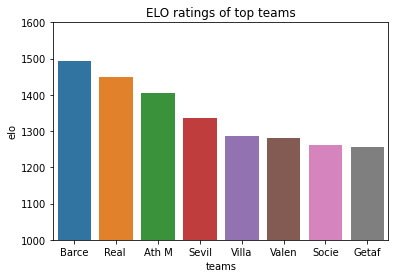

In [16]:
topteams2=teamstable.head(8)
k=[]
for i in topteams2['Team']:
    k.append(i[0:5])
topteams2["prefix"] = k
plt.title("ELO ratings of top teams")
sns.barplot(x="prefix",y="elo",data=topteams2)
plt.xlabel("teams")
plt.ylim(1000,1600)
plt.show()

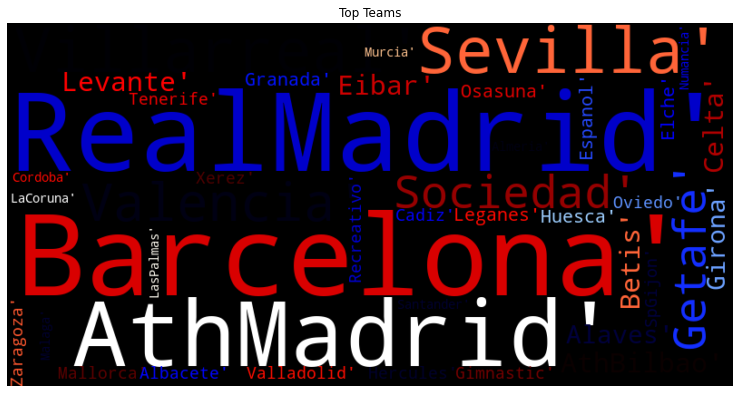

In [15]:
# Build a word cloud
def wordCloud(df,title):
    wrd2=[]
    wrd= list(df)
    wrd =wrd[0:50]
    for i in wrd:
        if(type(i) == str):
            i=i.replace(" ","")
            wrd2.append(i)
        else:
            break
    wc = WordCloud(background_color="black",scale =2,colormap="flag").generate(str(wrd2))
    plt.figure(figsize=(13,8))
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()
wordCloud(teamstable['Team'],"Top Teams")

## Ranking players on the basis of Striker, Midfielder and Defender

In [49]:
# We will compute player scores on the basis of various attributes relavant to the playstyle
finalscores = pd.DataFrame()
finalscores['name'] = players['name']
maxscore = -1

def givescorehelper(features,weightage):
    val=0
    cc=0
    for i in range(0, len(features)):
        if(pd.isna(features[i])):
            continue
        val+=features[i]*weightage[i]
        cc+=weightage[i]
    if(cc==0):
        return
    return val/cc

def roundoff(x):
    if(pd.isna(x)):
        return
    global maxscore
    fact=100/maxscore
    return round(x*fact)

# function for finding Score of players
def givescore(stylename , featurenames ,weightage):
    global maxscore
    maxscore=-1
    for i,row in playerscores.iterrows():
        name=row['name']
        features=[]
        for x in featurenames:
            features.append(playerscores.loc[i,x])
        
        score=givescorehelper(features,weightage)
        if(score==None):
            continue
        maxscore=max(maxscore,score)
        finalscores.loc[i,stylename]=score
    finalscores[stylename]=finalscores[stylename].apply(roundoff)

## Giving scores to players according to different positions

In [50]:
# this is where we give scores according to playing position
# Striker
givescore('striker',['goals_pens_per90','shots_on_target_per90','aerials_won','shots_free_kicks'],[2,1,0.1,1])

# Midfielder
givescore('midfielder',['assists_per90','goals_per90','carry_distance','passes_completed','tackles_won','pressure_regains','dribbles_completed'],[2,0.3,0.2,0.5,0.5,0.5,0.5])

# Defender
givescore('defender',['tackles_won','pressures','pressure_regains','blocks','blocked_shots','fouls','aerials_won','ball_recoveries','passes_completed_medium' ,'passes_completed_long','carry_distance' ],[3,0.5,1,0.5,3,0.5,0.5,2,2,1,1])

## Top Strikers

In [53]:
# list of players based on striker score
pp2 = finalscores.sort_values(by="striker",ascending=False)
pp2.head()

,name,striker,midfielder,defender,avg
288,Lionel Messi,100.0,96.0,63.0,86.333333
296,Luis Suárez,99.0,90.0,57.0,82.000000
324,Maxi Gómez,98.0,69.0,58.0,75.000000
232,Darwin Machís,97.0,86.0,60.0,81.000000
413,Iago Aspas,97.0,88.0,72.0,85.666667


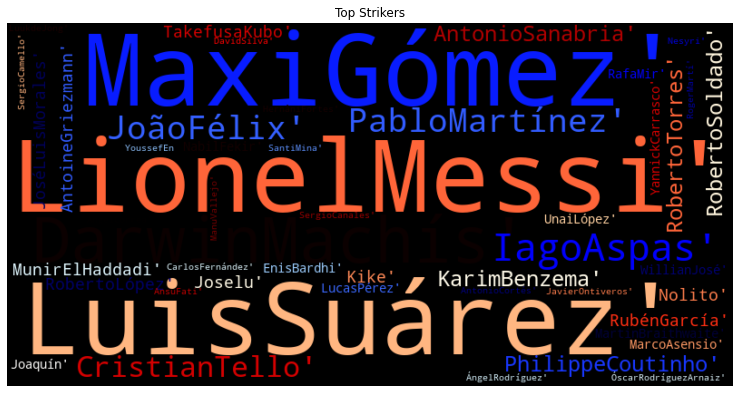

In [55]:
wordCloud(pp2['name'],"Top Strikers")

* Clearly Lionel Messi, Luis Suarez and Maxi Gomez are top 3 La-Liga Strikers.
* All the players having significant font weight in above word cloud would be best transfer players for striker category.

## Top Midfielders

In [28]:
# list of players based on midfielder score
pp=finalscores.sort_values(by="midfielder",ascending=False)
pp.head()

,name,striker,midfielder,defender
149,Nabil Fekir,89.0,100.0,81.0
114,José Campaña,69.0,99.0,96.0
143,Sergio Canales,85.0,99.0,85.0
419,Joan Jordán,71.0,99.0,94.0
181,Mikel Merino,82.0,98.0,95.0


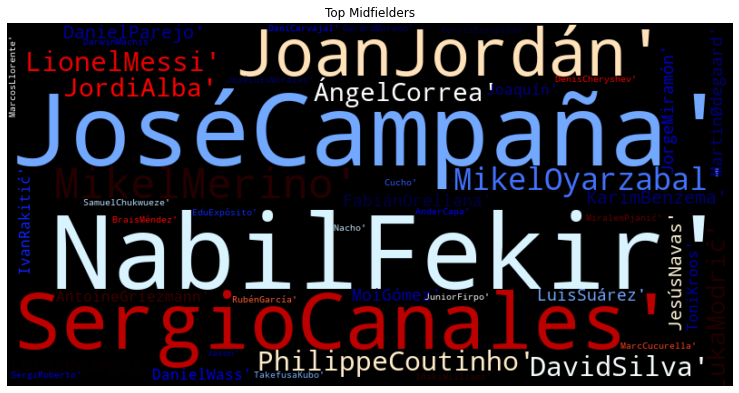

In [282]:
wordCloud(pp['name'],"Top Midfielders") 

* Clearly Nabil Fekir, Jose Campana and Sergio Canales are top 3 midfielders.
* All the players having significant font weight in above word cloud would be best transfer players for midfielders category.

## Top Defenders

In [283]:
# list of players based on best defender score
pp3=finalscores.sort_values(by="defender",ascending=False)
pp3.head()

,name,striker,midfielder,defender
190,Marc Bartra,62.0,68.0,100.0
439,Casemiro,70.0,75.0,100.0
300,Saúl Ñíguez,73.0,71.0,99.0
213,Daniel Parejo,70.0,93.0,99.0
282,Sergio Busquets,36.0,75.0,98.0


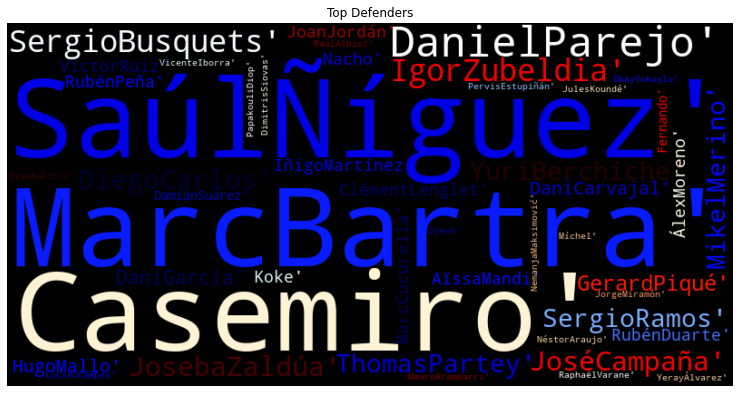

In [284]:
wordCloud(pp3['name'],"Top Defenders")

* Clearly Marc Bartra, Casemiro and Saul Niguez are top Defenders.
* All the players having significant font weight in above word cloud would be best transfer players for defenders category.

### Best players on basis of average attributes.

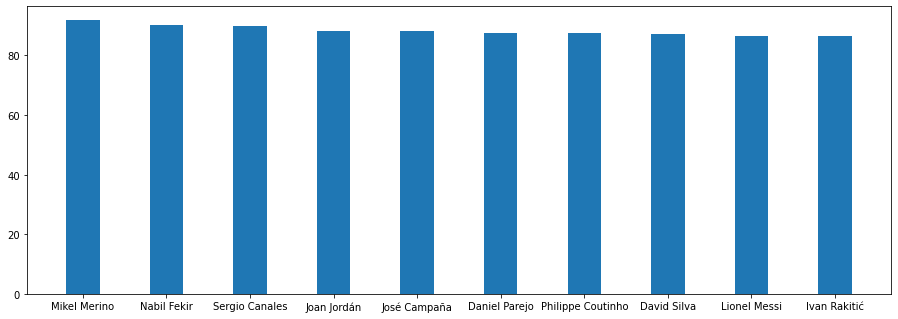

In [51]:
#Calculating average scores of all players.
finalscores['avg'] = (finalscores['striker'] + finalscores['defender'] + finalscores['midfielder'])/3
f1=finalscores.sort_values(by="avg",ascending=False)
#taking top 10 players.
f2=f1.head(10)
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
name = f2['name']
avg = f2['avg']
ax.bar(name,avg, width=0.4)
plt.show()

* These above players have best average attributes so they would be best for a season transfers for a team who are looking for good players to purchase.

## Correlation between Shots vs goals

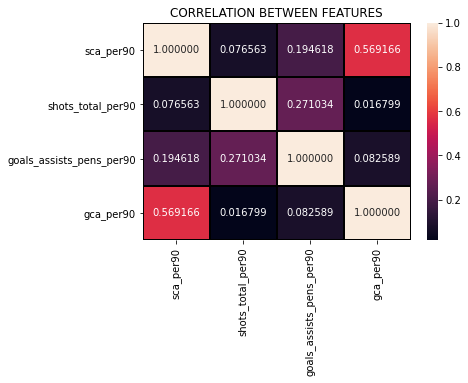

In [285]:
correlation = players[['sca_per90','shots_total_per90','goals_assists_pens_per90','gca_per90']].corr()
sns.heatmap(correlation,annot=True,fmt="f",linecolor="k",linewidths=1)
plt.title("CORRELATION BETWEEN FEATURES")
plt.show()

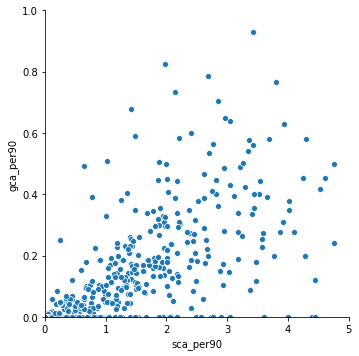

In [286]:
bx = sns.relplot(data=players, x="sca_per90", y="gca_per90")
xlim = bx.set(xlim=(0,5))
ylim = bx.set(ylim=(0,1))

* In the above corelation matrix we can see a corelation of 0.569 between Goals creation action per 90 and shot creation action per 90
* which is essentially signifying that to score more goals more shots or shots created has to be made.

## Home Wins vs Away Wins vs Draws

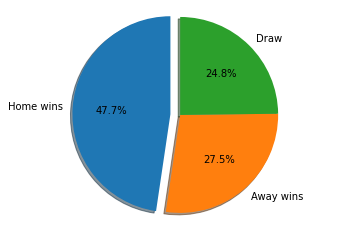

In [287]:
#Decalaring variables for home win,away win and draw count.
hometeam=0
awayteam=0
draw=0
df1 = pd.DataFrame(matches, columns=['FTHG'])
df2 = pd.DataFrame(matches, columns=['FTAG'])
a1=[]
a2=[]
#calculating count of each home win,away win and draws.
for i in df1['FTHG']:
    a1.append(i)
for i in df2['FTAG']:
    a2.append(i)   
for i in range(len(a1)):
    if a1[i] > a2[i]:
        hometeam+=1
    elif a2[i] > a1[i]:
        awayteam+=1
    elif a1[i] == a2[i]:
        draw+=1
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Home wins', 'Away wins', 'Draw'
sizes = [hometeam,awayteam,draw]
explode = (0.1, 0, 0)  # only "explode" the 2nd slice 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

* We infer from above pie chart that Home match factor plays a significant role in a team's winning and losing.
* So a team playing at home have almost 75% chances of not losing the match

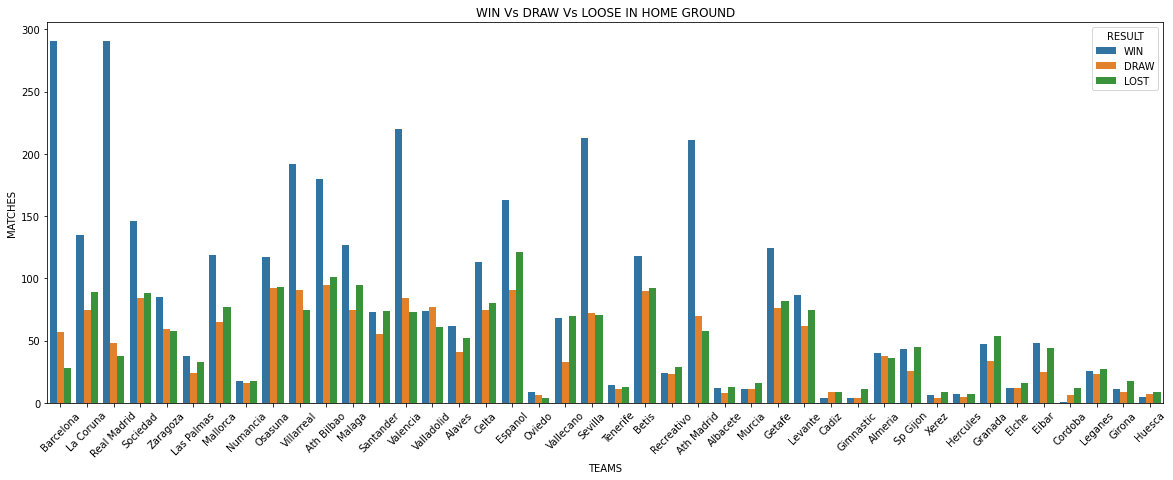

In [288]:
plt.figure(figsize=(20,7))
sns.countplot(x = matches["HomeTeam"], hue = matches['FTR']).set(xlabel='TEAMS', ylabel='MATCHES')
plt.title("WIN Vs DRAW Vs LOOSE IN HOME GROUND")
plt.legend(title='RESULT', labels=['WIN', 'DRAW', 'LOST'])
plt.xticks(rotation=45)
plt.show()

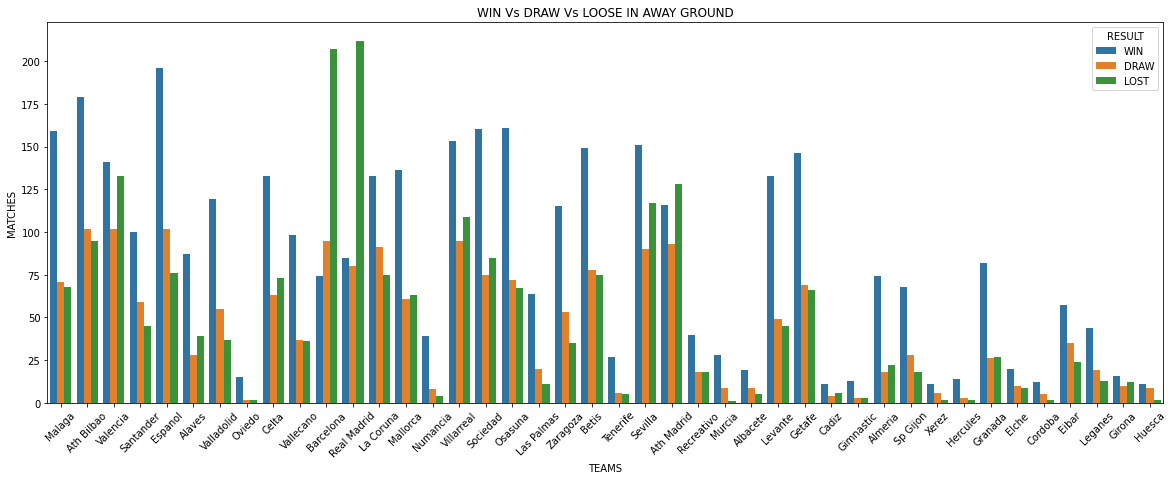

In [289]:
plt.figure(figsize=(20,7))
sns.countplot(x = matches["AwayTeam"], hue = matches['FTR']).set(xlabel='TEAMS', ylabel='MATCHES')
plt.title("WIN Vs DRAW Vs LOOSE IN AWAY GROUND")
plt.legend(title='RESULT', labels=['WIN', 'DRAW', 'LOST'])
plt.xticks(rotation=45)
plt.show()

* The graphs showing win Vs Draw Vs loose in home ground and in away ground supports the advange of HOME TEAM discussed later.
* Most of the teams have more wins in Home ground whereas in away ground only few teams, which are also on the top teams according to their elo rating have more wins than losses.

## Home and Away Goals In Every Season

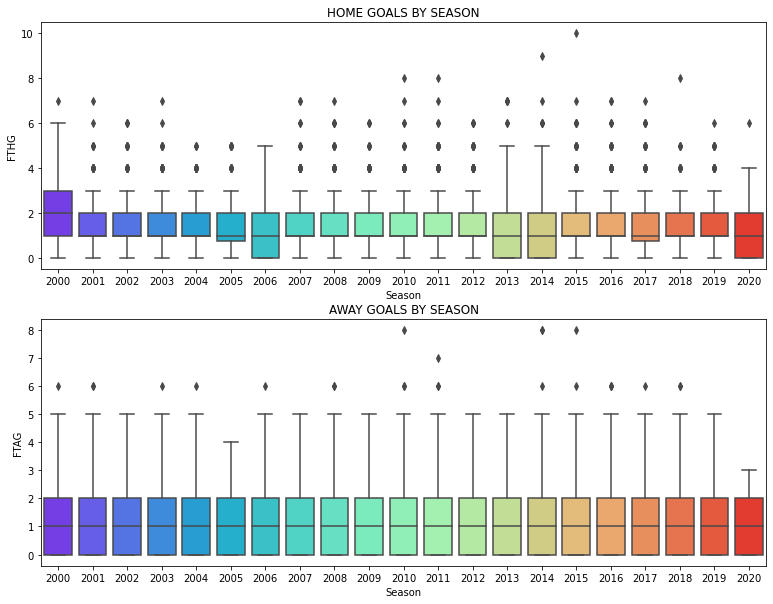

In [290]:
plt.figure(figsize=(13,10))
plt.subplot(211)
sns.boxplot(x = matches["Season"],y = matches["FTHG"],palette="rainbow")
#This will show goals scored by home teams in each match in every season box.
plt.title("HOME GOALS BY SEASON")
plt.subplot(212)
#This will show goals scored by away teams in each match in every season box.
sns.boxplot(x = matches["Season"],y = matches["FTAG"],palette="rainbow")
plt.title("AWAY GOALS BY SEASON")
plt.show()

* The above graph show how a team's scoring ability improves as it plays at its home turf.
* The significant amount of outliers in above upper quartile shows how teams score higher goals in more matches in home matches than away matches.
* In away matches only few outliers are there which are above upper quartile which shows most away teams are not able to score higher goals than median goals in away turf.

### Goals conceded by home teams

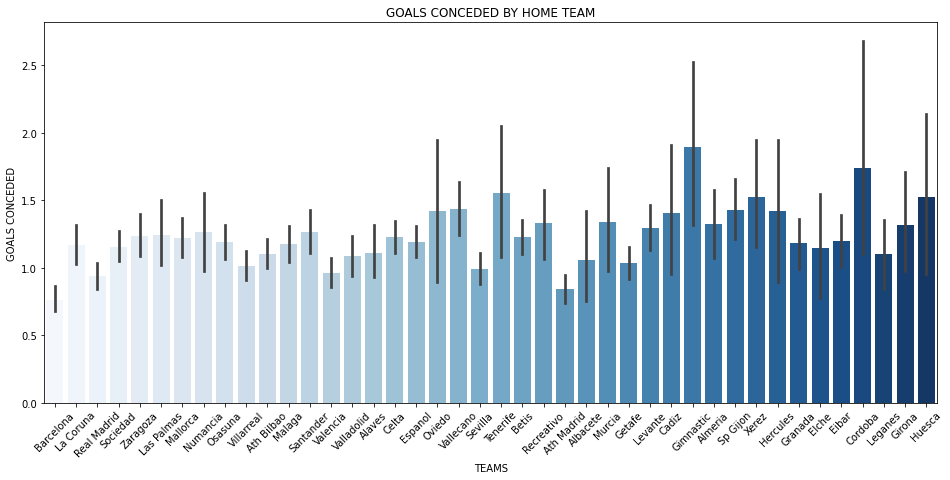

In [291]:
plt.figure(figsize=(16,7))
sns.barplot(x = matches["HomeTeam"],
            y = matches["FTAG"],
            palette = "Blues").set(xlabel='TEAMS', ylabel='GOALS CONCEDED')
plt.xticks(rotation=45)
plt.title("GOALS CONCEDED BY HOME TEAM")
plt.show()

### Goals conceded by away teams

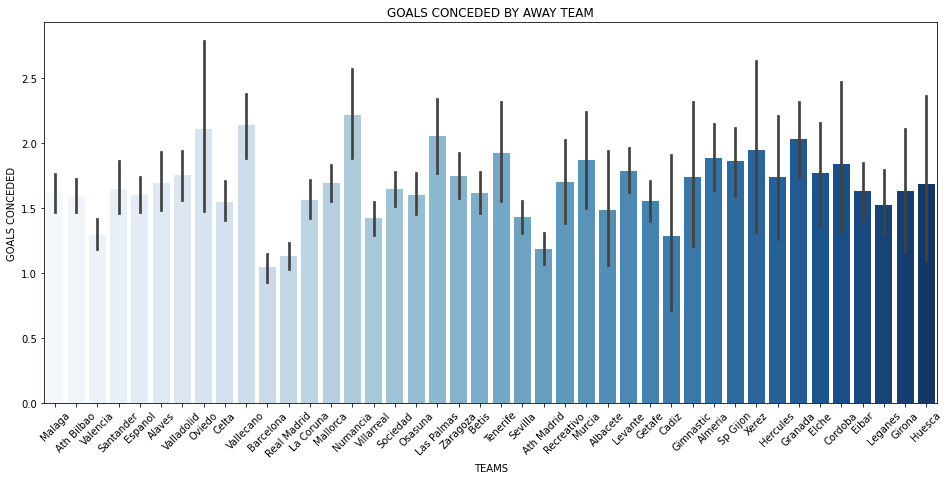

In [292]:
plt.figure(figsize=(16,7))
sns.barplot(x = matches["AwayTeam"],
            y = matches["FTHG"],
            palette = "Blues").set(xlabel='TEAMS', ylabel='GOALS CONCEDED')
plt.title("GOALS CONCEDED BY AWAY TEAM")
plt.xticks(rotation=45)
plt.show()

* In the above two graphs, we can see that there are more goals conceded by away team than the home team.
* this is because of HOME GROUND advantage, because the home team is experienced and comfortable in their home ground plus the audience is heavily in favor of the home team.

## Count of Matches played between top 20 teams

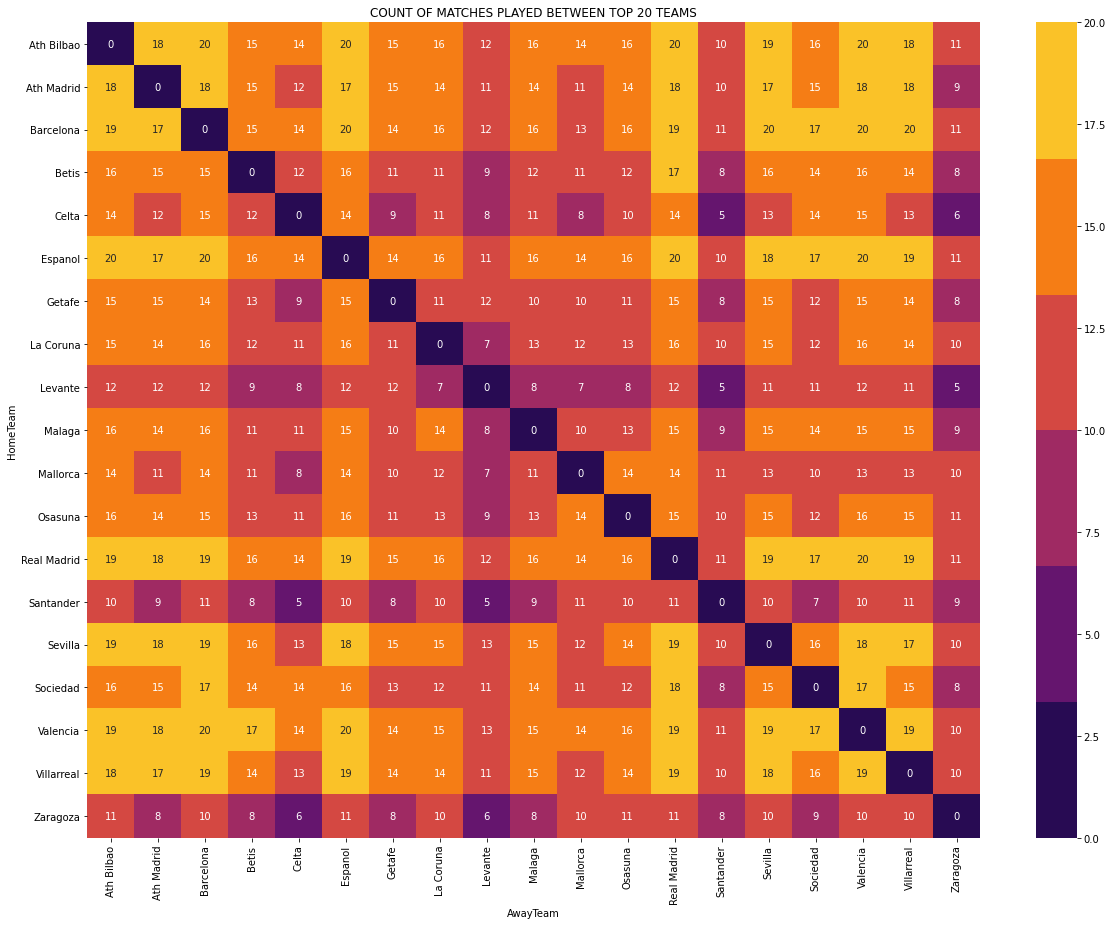

In [293]:
def label(matches):
    if matches["FTR"] == "H":
        return matches["HomeTeam"]
    elif matches["FTR"] == "A" :
        return matches["AwayTeam"]
    elif matches["FTR"] == "D":
        return "DRAW"

matches["win"] = matches.apply(lambda matches:label(matches),axis=1)
i = matches["win"].value_counts()[1:20].index
c = matches[(matches["HomeTeam"].isin(i)) & (matches["AwayTeam"].isin(i))]
d = pd.crosstab(c["HomeTeam"],c["AwayTeam"])
plt.figure(figsize=(20,15))
sns.heatmap(d,annot=True,cmap=sns.color_palette("inferno"))
plt.title("COUNT OF MATCHES PLAYED BETWEEN TOP 20 TEAMS")
plt.show()

* The more older teams of la liga have played significantly higher matches than newer teams which show why all top laliga teams are among the oldest ones.

# Feature Extraction

In [294]:
def getform(ht, at, i):
    global matches
    htdatalast20 = {'wins': 0, 'goaldiff': 0}
    atdatalast20 = {'wins': 0, 'goaldiff': 0}
    htfound = 0
    atfound = 0
    versusdatalast5 = {'wins': 0, 'goaldiff': 0}
    versusfound = 0
    kk = i-1
    dictt={}
    for j in range(kk, 0, -1):
        cht = matches.loc[j, 'HomeTeam']
        cat = matches.loc[j, 'AwayTeam']
        if(htfound < 20):
            if(cht == ht):
                htfound += 1
                htdatalast20['goaldiff'] += matches.loc[j,'FTHG'] - matches.loc[j, 'FTAG']
                if(matches.at[j, 'FTR'] == 'D'):
                    htdatalast20['wins'] += 0.5
                elif(matches.at[j, 'FTR'] == 'H'):
                    htdatalast20['wins'] += 1
                else:
                    None
            if(cat == ht):
                htfound += 1
                htdatalast20['goaldiff'] -= (matches.loc[j,'FTHG'] - matches.loc[j, 'FTAG'])
                if(matches.at[j, 'FTR'] == 'D'):
                    htdatalast20['wins'] += 0.5
                elif(matches.at[j, 'FTR'] == 'H'):
                    htdatalast20['wins'] -= 1
                else:
                    None
        if(atfound < 20):
            if(cht == at):
                atfound += 1
                atdatalast20['goaldiff'] += (matches.loc[j, 'FTHG'] - matches.loc[j, 'FTAG'])
                if(matches.at[j, 'FTR'] == 'D'):
                    atdatalast20['wins'] += 0.5
                elif(matches.at[j, 'FTR'] == 'H'):
                    atdatalast20['wins'] += 1
                else:
                        None
            if(cat == at):
                atfound += 1
                atdatalast20['goaldiff'] -= (matches.loc[j,'FTHG'] - matches.loc[j, 'FTAG'])
                if(matches.at[j, 'FTR'] == 'D'):
                    atdatalast20['wins'] += 0.5
                elif(matches.at[j, 'FTR'] == 'H'):
                    atdatalast20['wins'] -= 1
                else:
                        None
        if(versusfound < 5):
            if((cht == ht and cat == at) or (cht == at and cat == ht)):
                versusfound += 1
                if(cht == ht):
                    versusdatalast5['goaldiff'] += matches.loc[j,'FTHG'] - matches.loc[j, 'FTAG']
                    if(matches.at[j, 'FTR'] == 'D'):
                        versusdatalast5['wins'] += 0.5
                    elif(matches.at[j, 'FTR'] == 'H'):
                        versusdatalast5['wins'] += 1
                    else:
                        None
                else:
                    versusdatalast5['goaldiff'] -= (matches.loc[j, 'FTHG'] - matches.loc[j, 'FTAG'])
                    if(matches.at[j, 'FTR'] == 'D'):
                        versusdatalast5['wins'] += 0
                    elif(matches.at[j, 'FTR'] == 'H'):
                        versusdatalast5['wins'] -= 1
                    else:
                        None
        if (htfound==5):
            dictt['htgdlast5']=htdatalast20['goaldiff']
            dictt['htwinslat5']=htdatalast20['wins']
        if (atfound==5):
            dictt['atgdlast5']=atdatalast20['goaldiff']
            dictt['atwinslat5']=atdatalast20['wins']
        if (htfound==10):
            dictt['htgdlast10']=htdatalast20['goaldiff']
            dictt['htwinslat10']=htdatalast20['wins']
        if (atfound==10):
            dictt['atgdlast10']=atdatalast20['goaldiff']
            dictt['atwinslat10']=atdatalast20['wins']
        if(versusfound == 5 and htfound == 20 and atfound == 20):
            break

    if(versusfound==5 and htfound==20 and atfound==20):
        dictt.update({'ht':ht,'at':at,'htwinslast20':htdatalast20['wins'],'atwinslast20':atdatalast20['wins'],\
                'htgdlast20':htdatalast20['goaldiff'],'atgdlast20':atdatalast20['goaldiff'],\
                'versuslast5':versusdatalast5['wins']\
                })
        return dictt

### Prepares features

Note- THis block can take a lot of time to run. You can skip this block as it saves the output in csv file and subsequent blocks use that file.The file is already shipped with the code

In [295]:

modeldata=pd.DataFrame()
for i , row in matches.iterrows():
   if(i > 1000):
           dictt=getform(matches.at[i,'HomeTeam'],matches.at[i,'AwayTeam'],i)
           if(dictt!=None):
               dictt['result']=matches.at[i,'FTR']
               modeldata=modeldata.append(dictt,ignore_index=True)
   if(i%1000==0):
       print(i)
modeldata.to_csv('modeldata.csv' , index=False)

In [296]:
modeldata=pd.read_csv('modeldata.csv')
modeldata.head()

,at,atgdlast10,atgdlast20,atgdlast5,atwinslast20,atwinslat10,atwinslat5,ht,htgdlast10,htgdlast20,htgdlast5,htwinslast20,htwinslat10,htwinslat5,result,versuslast5
0,Villarreal,-2.0,-2.0,-1.0,4.5,0.5,1.0,La Coruna,11.0,11.0,10.0,5.0,1.5,1.5,H,-0.5
1,Ath Bilbao,5.0,2.0,4.0,4.5,3.5,3.0,Malaga,0.0,-3.0,0.0,2.0,1.0,-1.5,H,0.0
2,Alaves,-10.0,-15.0,-11.0,1.0,0.5,-0.5,Sociedad,-1.0,5.0,-5.0,6.5,0.5,-1.5,H,-0.5
3,Celta,3.0,2.0,4.0,2.0,2.0,2.0,Vallecano,-9.0,-13.0,-6.0,-2.5,-1.5,-0.5,H,2.0
4,Vallecano,-7.0,-12.0,-5.0,-2.0,-0.5,0.0,La Coruna,11.0,14.0,9.0,6.0,2.5,2.5,H,0.0


In [297]:
modeldata.describe()

,atgdlast10,atgdlast20,atgdlast5,atwinslast20,atwinslat10,atwinslat5,htgdlast10,htgdlast20,htgdlast5,htwinslast20,htwinslat10,htwinslat5,versuslast5
count,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000
mean,0.954283,1.772446,0.647858,3.015651,1.636738,0.983834,0.603377,1.476112,0.145387,2.687397,1.211491,0.446458,0.023785
std,8.353935,14.888141,4.969730,3.437849,2.110574,1.378105,8.350560,14.827628,4.932153,3.425941,2.146239,1.410427,1.353373
min,-23.000000,-38.000000,-18.000000,-7.500000,-4.500000,-3.000000,-22.000000,-41.000000,-15.000000,-7.000000,-5.500000,-4.000000,-4.000000
25%,-5.000000,-8.000000,-3.000000,0.500000,0.000000,0.000000,-5.000000,-8.000000,-3.000000,0.500000,-0.500000,-0.500000,-1.000000
50%,0.000000,-1.000000,0.000000,3.000000,1.500000,1.000000,-1.000000,-1.000000,0.000000,2.500000,1.000000,0.500000,0.000000
75%,5.000000,8.000000,3.000000,5.500000,3.000000,2.000000,5.000000,8.000000,3.000000,5.000000,3.000000,1.500000,1.000000
max,37.000000,59.000000,23.000000,12.000000,7.500000,4.500000,39.000000,59.000000,25.000000,13.000000,7.500000,4.000000,3.000000


# Models

In [298]:
df = pd.read_csv("modeldata.csv")
df.columns

Index(['at', 'atgdlast10', 'atgdlast20', 'atgdlast5', 'atwinslast20',
       'atwinslat10', 'atwinslat5', 'ht', 'htgdlast10', 'htgdlast20',
       'htgdlast5', 'htwinslast20', 'htwinslat10', 'htwinslat5', 'result',
       'versuslast5'],
      dtype='object')

In [299]:
xfeatures=['atgdlast10', 'atgdlast20', 'atgdlast5', 'atwinslast20',
       'atwinslat10', 'atwinslat5', 'htgdlast10', 'htgdlast20',
       'htgdlast5', 'htwinslast20', 'htwinslat10', 'htwinslat5',
       'versuslast5']

In [300]:
X = df[xfeatures]
Y = df['result']

In [301]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [302]:
# Standardizing the features
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

In [303]:
## Train classifier
def train_classifier(cls, X_train, y_train):
    cls.fit(X_train, y_train)
    
def predict_labels(cls, features, target):
    # Makes predictions using a fit classifier based on F1 score.
    y_pred = cls.predict(features)
    return cls.score(features, target) ,y_pred

def train_predict(cls, X_train, y_train, X_test, y_test):
    print("Training a {} using a training set size of {} ".format(cls.__class__.__name__, len(X_train)))

    # Train the classifier
    train_classifier(cls, X_train, y_train)

    # Print the results of prediction for both training and testing
    acc , predictions = predict_labels(cls, X_train, y_train)
    print("for training set")
    print("accuracy :", acc)
    print('')
    
    acc , predictions= predict_labels(cls, X_test, y_test)
    print("for test set")
    print("accuracy :", acc)
    return predictions ,acc

## Plot confusion matrix
def plot_confusion(predictions ,y_test, score):
    cm = metrics.confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'OrRd');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 10);

# MultiClass Classification HOME  AWAY  DRAW

## Logistic Regression

Training a LogisticRegression using a training set size of 3399 
for training set
accuracy : 0.517799352750809

for test set
accuracy : 0.5216197666437886


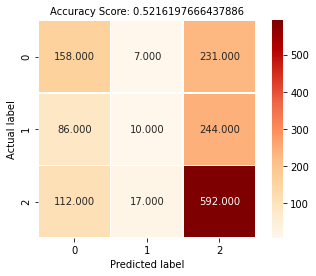

In [304]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
pred ,acc = train_predict(lr,x_train, y_train,x_test, y_test)
plot_confusion( pred , y_test ,acc)

## Decision Tree Classifier

Training a DecisionTreeClassifier using a training set size of 3399 
for training set
accuracy : 0.511326860841424

for test set
accuracy : 0.5223061084420041


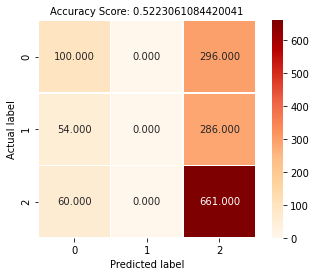

In [305]:
dtree_model = DecisionTreeClassifier(max_depth = 2)
pred ,acc= train_predict(dtree_model,x_train, y_train,x_test, y_test)
plot_confusion( pred , y_test, acc)

## K Neighbors Classifier

Training a KNeighborsClassifier using a training set size of 3399 
for training set
accuracy : 0.6004707266843189

for test set
accuracy : 0.43308167467398767


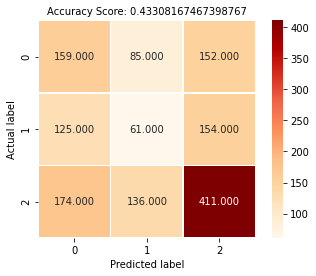

In [306]:
knn = KNeighborsClassifier(n_neighbors = 7)
pred ,acc= train_predict(knn,x_train, y_train,x_test, y_test)
plot_confusion( pred , y_test, acc)

## XGBoost Model

Training a XGBClassifier using a training set size of 3399 
for training set
accuracy : 0.5436893203883495

for test set
accuracy : 0.5284831846259437


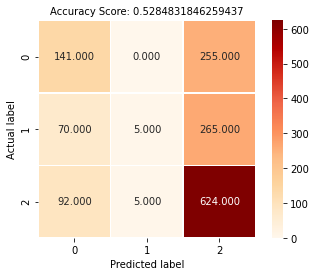

In [307]:
## Tweaks the parameters using Cross validation
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'reg_alpha':[1e-5]
             }  

clf = xgb.XGBClassifier(objective='multi:softmax',num_class=3)

scorer = make_scorer(f1_score, average = 'micro')
grid_obj = GridSearchCV(clf,
                        scoring=scorer,
                        param_grid=parameters,
                        cv=10)
grid_obj = grid_obj.fit(x_train,y_train)
clf = grid_obj.best_estimator_
pred ,acc= train_predict(clf,x_train, y_train,x_test, y_test)
plot_confusion( pred , y_test, acc)

# Trying to see if HOME TEAM WINS OR NOT

In [308]:
for i,row in modeldata.iterrows():
    if(row.result=='H'):
        df.at[i,'HomeTeamWin']='Y'
    else:
        df.at[i,'HomeTeamWin']='N'
Y = df['HomeTeamWin']

In [309]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
# Standardizing the features
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

## Logistic Regression

Training a LogisticRegression using a training set size of 3399 
for training set
accuracy : 0.6384230656075316

for test set
accuracy : 0.6252573781743308


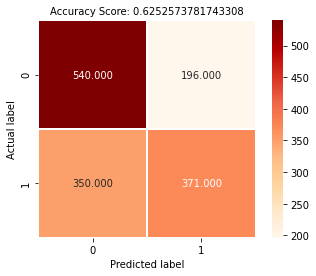

In [310]:
lrhome = LogisticRegression()
pred ,acc = train_predict(lrhome,x_train, y_train,x_test, y_test)
plot_confusion( pred , y_test ,acc)

## Decision Tree Classifier

Training a DecisionTreeClassifier using a training set size of 3399 
for training set
accuracy : 0.6160635481023831

for test set
accuracy : 0.5998627316403569


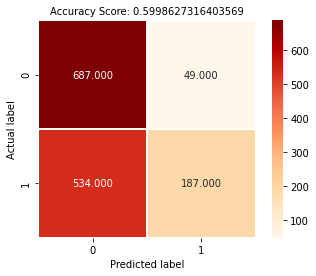

In [311]:
dtree_modelhome = DecisionTreeClassifier(max_depth = 2)
pred ,acc= train_predict(dtree_modelhome,x_train, y_train,x_test, y_test)
plot_confusion( pred , y_test, acc)

## XGBoost Model

Training a XGBClassifier using a training set size of 3399 
for training set
accuracy : 0.6587231538687849

for test set
accuracy : 0.632120796156486


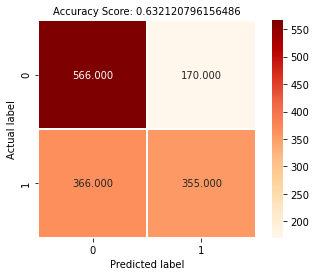

In [312]:
# TODO: Create the parameters list you wish to tune
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'reg_alpha':[1e-5]
             }  
xgbmodelhome = xgb.XGBClassifier(seed=82)
scorer = make_scorer(accuracy_score)
grid_obj = GridSearchCV(clf,
                        scoring=scorer,
                        param_grid=parameters,
                        cv=10)
grid_obj = grid_obj.fit(x_train,y_train)
xgbmodelhome = grid_obj.best_estimator_
pred ,acc= train_predict(xgbmodelhome,x_train, y_train,x_test, y_test)
plot_confusion( pred , y_test, acc)

# Trying to see if AWAY TEAM WINS OR NOT

In [313]:
for i,row in modeldata.iterrows():
    if(row.result=='A'):
        df.at[i,'AwayTeamWin']='Y'
    else:
        df.at[i,'AwayTeamWin']='N'
Y=df['AwayTeamWin']

In [314]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
# Standardizing the features
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

## Logistic Regression

Training a LogisticRegression using a training set size of 3399 
for training set
accuracy : 0.732568402471315

for test set
accuracy : 0.7295813315030886


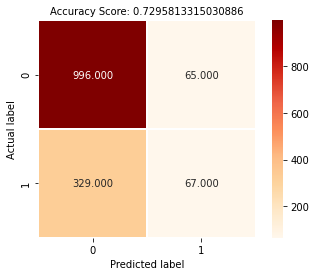

In [315]:
lraway = LogisticRegression()
pred ,acc = train_predict(lraway,x_train, y_train,x_test, y_test)
plot_confusion( pred , y_test ,acc)

## Decision Tree Classifier

Training a DecisionTreeClassifier using a training set size of 3399 
for training set
accuracy : 0.7349220358929097

for test set
accuracy : 0.7343857240905971


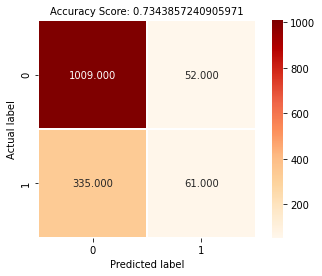

In [316]:
dtree_modelaway = DecisionTreeClassifier(max_depth = 2)
pred ,acc= train_predict(dtree_modelaway,x_train, y_train,x_test, y_test)
plot_confusion( pred , y_test, acc)

## XGBoost Model

Training a XGBClassifier using a training set size of 3399 
for training set
accuracy : 0.7481612238893792

for test set
accuracy : 0.7412491420727523


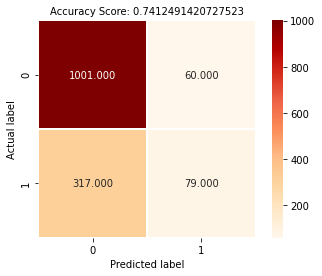

In [317]:
# Create the parameters list 
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'reg_alpha':[1e-5]
             }  
xgbmodelhome = xgb.XGBClassifier(seed=82)
scorer = make_scorer(accuracy_score)
grid_obj = GridSearchCV(clf,
                        scoring=scorer,
                        param_grid=parameters,
                        cv=10)
grid_obj = grid_obj.fit(x_train,y_train)
xgbmodelhome = grid_obj.best_estimator_
pred ,acc= train_predict(xgbmodelhome,x_train, y_train,x_test, y_test)
plot_confusion( pred , y_test, acc)